In [ ]:
import pandas as pd
import numpy as np
import shap
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [20]:
# load dataset
df = pd.read_csv('../../datasets/atis_dataset_preprocessed.csv', sep=';')

In [21]:
# define label columns
label_columns = ['ILS', 'RNAV', 'RNP', 'VISUAL']

# define features and targets
X = df.drop(columns=label_columns)

# one-hot encode features that are categorical
X = pd.get_dummies(X, columns=['airport_icao', 'runway_designator_side', 'weather_phenomenon', 
                                'runway_designator_number', 'rvr_tendency', 'runway_ils_category'])

In [22]:
y = df[label_columns]

In [23]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

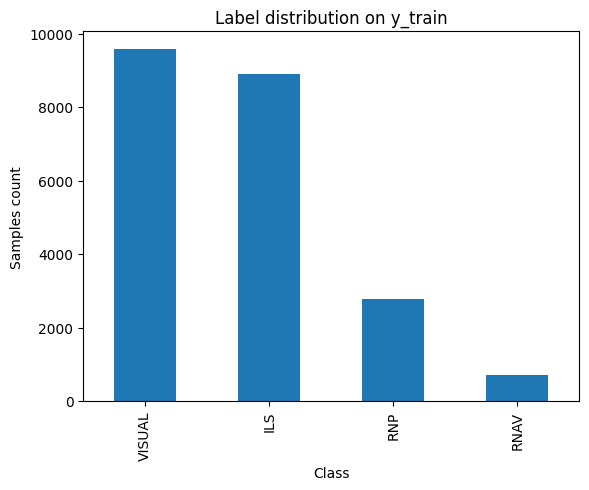

Label distribution:
 VISUAL    9576
ILS       8904
RNP       2782
RNAV       698
dtype: int64


In [24]:
# check for label distribution
label_counts = y_train.sum().sort_values(ascending=False)
label_counts.plot(kind='bar')
plt.title('Label distribution on y_train')
plt.xlabel('Class')
plt.ylabel('Samples count')
plt.show()

print("Label distribution:\n", label_counts)

In [ ]:
# oversampling imbalanced labels
try:
    X_train_sm, y_train_sm = SMOTE(random_state=42).fit_resample(X_train, y_train)
    print("SMOTE successful. X_train after SMOTE:", X_train_sm.shape)
    print("Label distribution after SMOTE:\n", pd.DataFrame(y_train_sm, columns=label_columns).sum())
    X_train_use, y_train_use = X_train_sm, y_train_sm
except Exception as e:
    print("SMOTE failed for multi-label")
    X_train_use, y_train_use = X_train, y_train

In [ ]:
# build and train multi-label model
model = OneVsRestClassifier(XGBClassifier(eval_metric='logloss'))

# build and train multi-label model
model.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END estimator__colsample_bytree=1.0, estimator__learning_rate=0.05, estimator__max_depth=7, estimator__n_estimators=100, estimator__subsample=1.0; total time=   0.5s
[CV] END estimator__colsample_bytree=1.0, estimator__learning_rate=0.05, estimator__max_depth=7, estimator__n_estimators=100, estimator__subsample=1.0; total time=   0.5s
[CV] END estimator__colsample_bytree=1.0, estimator__learning_rate=0.05, estimator__max_depth=7, estimator__n_estimators=100, estimator__subsample=1.0; total time=   0.5s
[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.2, estimator__max_depth=7, estimator__n_estimators=200, estimator__subsample=1.0; total time=   0.8s
[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.2, estimator__max_depth=7, estimator__n_estimators=200, estimator__subsample=1.0; total time=   1.1s
[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.2, estimator__ma

In [ ]:
# print(search.best_params_)

{'estimator__subsample': 1.0, 'estimator__n_estimators': 200, 'estimator__max_depth': 7, 'estimator__learning_rate': 0.2, 'estimator__colsample_bytree': 1.0}


In [ ]:
# cv_results = pd.DataFrame(model.cv_results_)
# cv_results.sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__subsample,param_estimator__n_estimators,param_estimator__max_depth,param_estimator__learning_rate,param_estimator__colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
21,1.304462,0.159502,0.075198,0.013944,1.0,200,7,0.20,1.0,"{'estimator__subsample': 1.0, 'estimator__n_es...",0.924568,0.918149,0.918736,0.920484,0.002898,1
1,0.967387,0.105887,0.058353,0.003073,1.0,200,7,0.20,0.7,"{'estimator__subsample': 1.0, 'estimator__n_es...",0.924161,0.917263,0.919095,0.920173,0.002918,2
31,0.999428,0.031149,0.073690,0.004983,1.0,100,7,0.20,1.0,"{'estimator__subsample': 1.0, 'estimator__n_es...",0.923609,0.917404,0.916961,0.919325,0.003035,3
7,1.295386,0.188851,0.064275,0.004689,1.0,200,7,0.10,1.0,"{'estimator__subsample': 1.0, 'estimator__n_es...",0.924444,0.916009,0.916554,0.919002,0.003854,4
29,1.370416,0.228278,0.061100,0.000191,0.7,200,7,0.05,1.0,"{'estimator__subsample': 0.7, 'estimator__n_es...",0.921345,0.916610,0.917250,0.918402,0.002098,5


In [32]:
# predict and evaluate
y_pred = model.predict(X_test)
empty_mask = y_pred.sum(axis=1) == 0
no_predictions = np.sum(empty_mask)
print(f"Samples with no predicted labels: {no_predictions} out of {len(y_pred)}")
print(X_test[empty_mask])
print(classification_report(y_test, y_pred, target_names=label_columns, zero_division=0))

Samples with no predicted labels: 40 out of 3819
       visibility  wind_speed  wind_gust  wind_direction     rvr  headwind  \
115          10.0           8          0             170  6000.0       5.1   
12911        10.0           8          0             210  6000.0       7.9   
11323        10.0           8          0             280  6000.0       8.0   
7613          9.0           3          0             130  6000.0       2.6   
5168         10.0           8          0             280  6000.0       8.0   
3507         10.0           6          0             130  6000.0      -5.2   
15157        10.0           3          0             220  6000.0       1.5   
15104        10.0           4          0             250  6000.0       3.5   
9790         10.0           8          0             280  6000.0       8.0   
8035         10.0           8          0             250  6000.0       6.9   
119          10.0           8          0             180  6000.0       6.1   
10098        10

In [ ]:
# per-class F1-score bar chart
report = classification_report(y_test, y_pred, output_dict=True)
f1_scores = [report[str(i)]['f1-score'] for i in range(len(label_columns))]
plt.figure(figsize=(8,4))
sns.barplot(x=label_columns, y=f1_scores)
plt.title("Per-Class F1 Score")
plt.ylabel("F1-score")
plt.show()

KeyError: 'ILS'

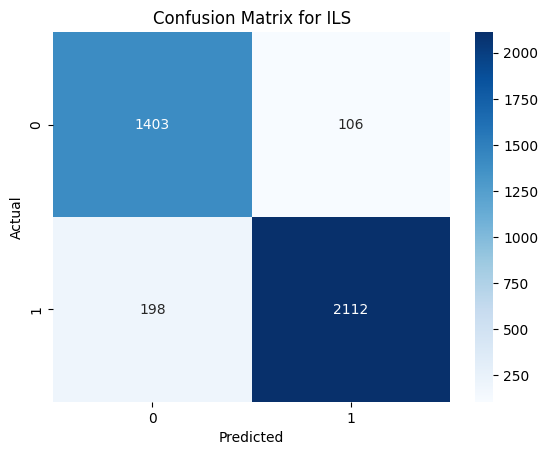

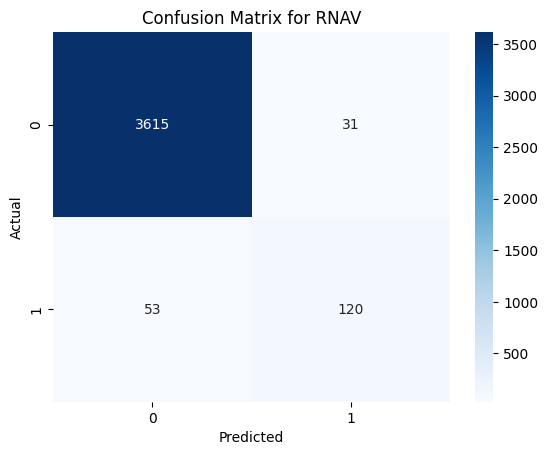

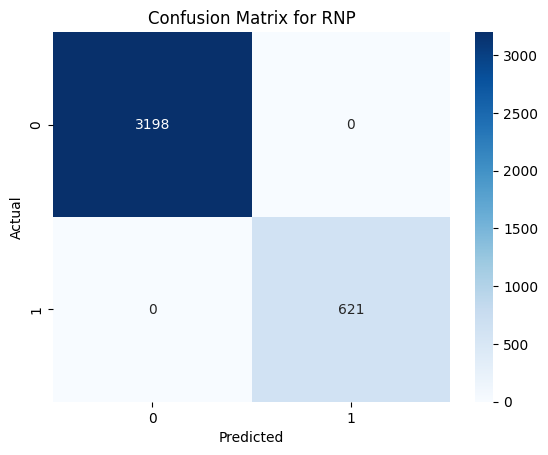

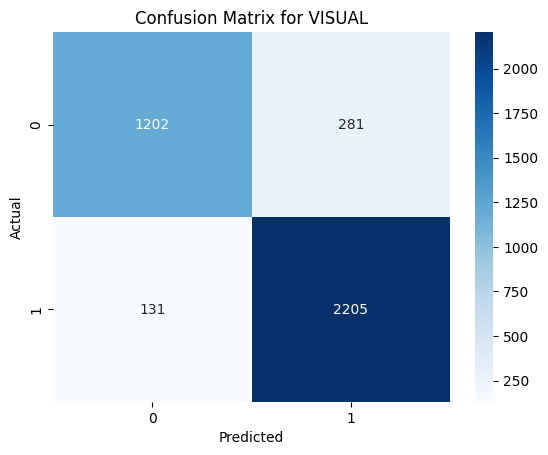

In [35]:
# confusion matrix per label
cm = multilabel_confusion_matrix(y_test, y_pred)
for i, label in enumerate(label_columns):
    plt.figure()
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

SHAP summary plot for ILS


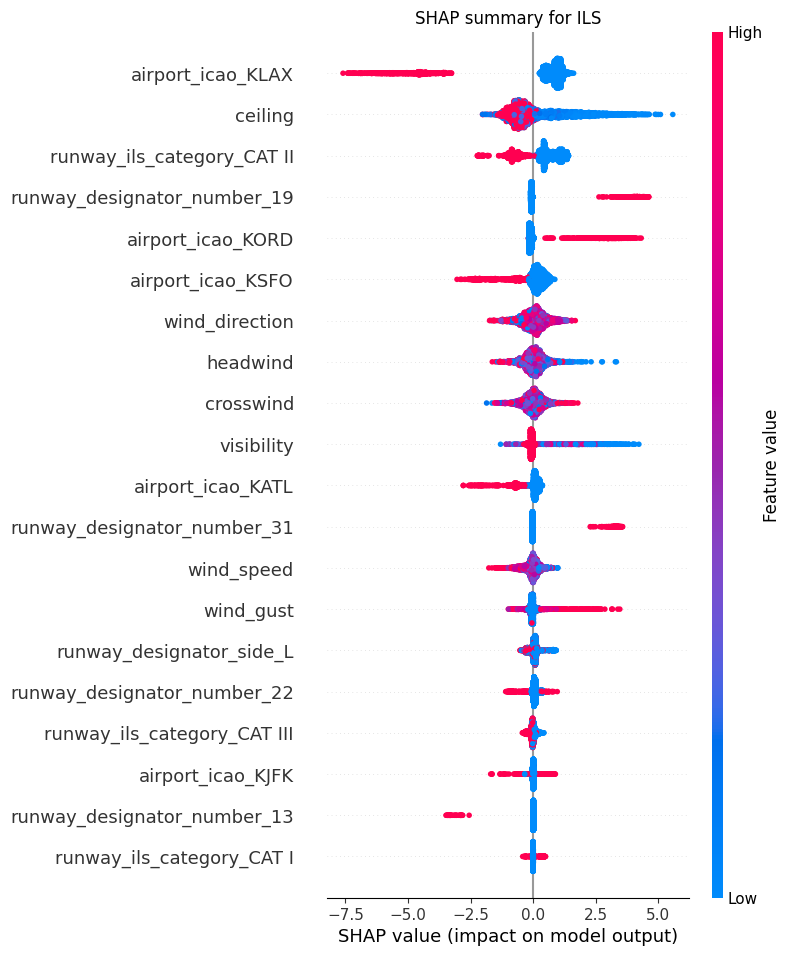

SHAP summary plot for RNAV


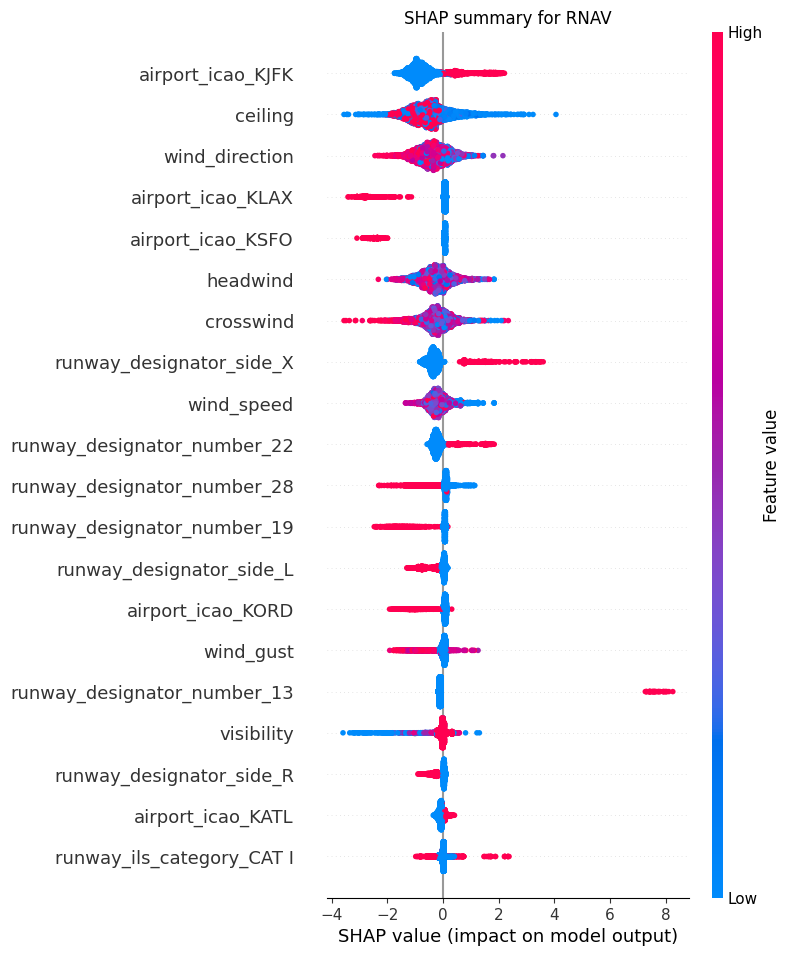

SHAP summary plot for RNP


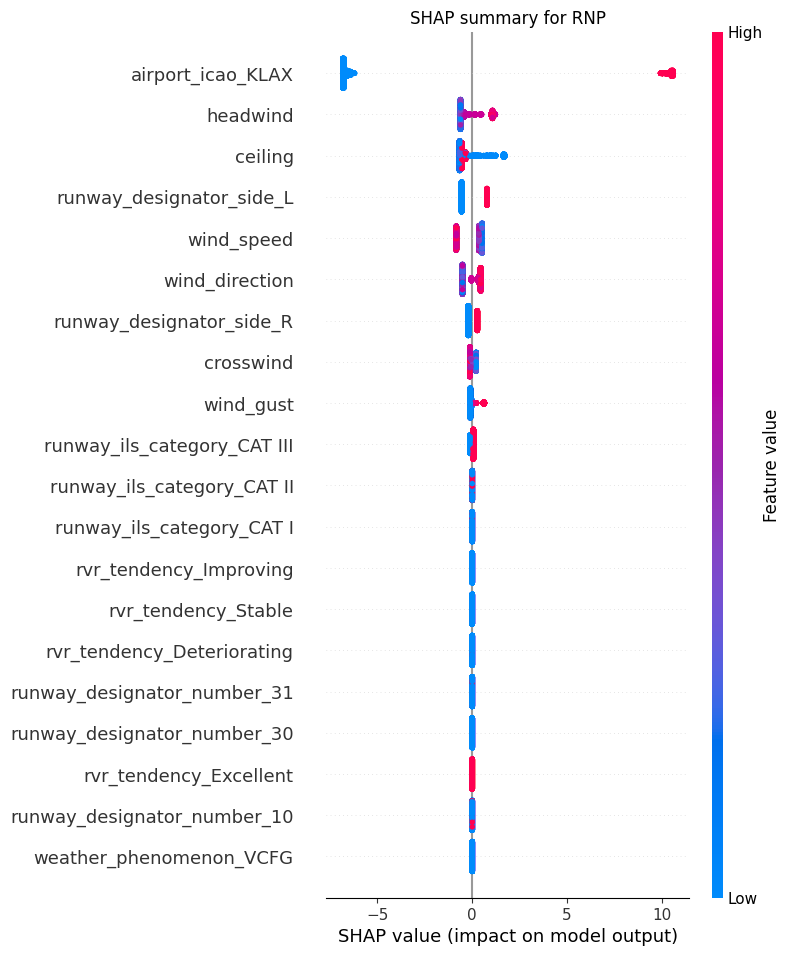

SHAP summary plot for VISUAL


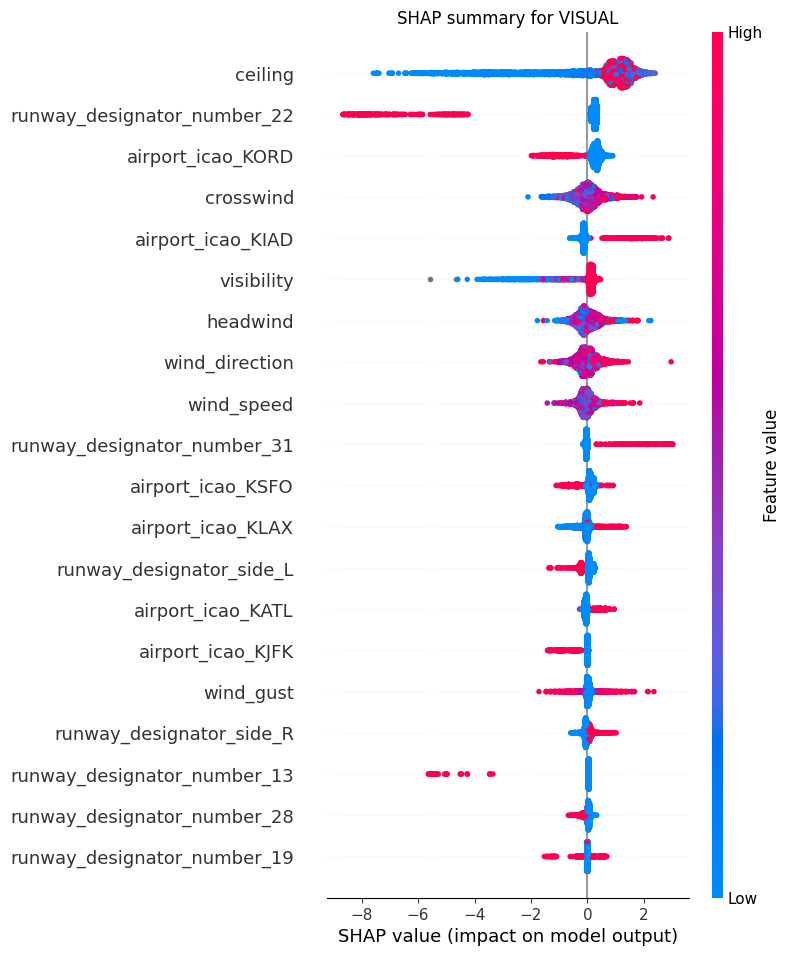

In [36]:
# SHAP summary plot per label
for idx, label in enumerate(label_columns):
    print(f"SHAP summary plot for {label}")
    explainer = shap.TreeExplainer(model.estimators_[idx])
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title(f"SHAP summary for {label}")
    plt.show()

In [37]:
# false predictions cases
for i, label in enumerate(label_columns):
    false_positives = np.where((y_test[label].values == 0) & (y_pred[:, i] == 1))[0]
    false_negatives = np.where((y_test[label].values == 1) & (y_pred[:, i] == 0))[0]
    print(f"\n{label} False Positives (max 5):")
    display(X_test.iloc[false_positives[:5]])
    print(f"{label} False Negatives (max 5):")
    display(X_test.iloc[false_negatives[:5]])


ILS False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III
466,10.0,6,0,100,6000.0,-3.0,-5.2,10000,False,False,...,False,False,False,False,True,False,False,False,False,True
13815,10.0,3,0,100,6000.0,3.0,0.0,25000,True,False,...,False,False,False,False,True,False,False,False,False,True
18371,10.0,18,0,250,6000.0,15.6,-9.0,1300,False,False,...,True,False,False,False,True,False,False,False,True,False
5564,10.0,8,0,190,6000.0,-0.0,-8.0,99999,True,False,...,True,False,False,False,True,False,False,False,True,False
17282,10.0,5,0,190,6000.0,-0.0,-5.0,20000,True,False,...,True,False,False,False,True,False,False,False,True,False


ILS False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III
5922,10.0,10,0,260,6000.0,9.4,-3.4,20000,False,False,...,True,False,False,False,True,False,False,False,True,False
15734,10.0,3,0,-1,6000.0,-0.5,3.0,6500,True,False,...,False,False,False,False,True,False,False,False,True,False
9149,10.0,4,0,60,6000.0,-3.1,2.6,99999,False,False,...,True,False,False,False,True,False,False,False,True,False
13485,10.0,6,0,220,6000.0,3.0,-5.2,99999,True,False,...,True,False,False,False,True,False,False,False,True,False
115,10.0,8,0,170,6000.0,5.1,-6.1,23000,False,False,...,False,False,False,False,True,False,False,False,False,True



RNAV False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III
16049,10.0,7,0,120,6000.0,-1.2,-6.9,1600,False,False,...,False,False,False,False,True,False,False,False,False,True
7499,10.0,8,0,110,6000.0,7.9,1.4,25000,True,False,...,False,False,False,False,True,False,False,False,False,True
16274,10.0,15,0,180,6000.0,11.5,-9.6,99999,False,False,...,False,False,False,False,True,False,False,False,False,True
4148,10.0,8,0,110,6000.0,7.9,1.4,25000,True,False,...,False,False,False,False,True,False,False,False,False,True
15574,10.0,17,0,200,6000.0,16.0,-5.8,25000,False,False,...,False,False,False,False,True,False,False,False,False,True


RNAV False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III
14378,7.0,6,0,140,6000.0,4.6,3.9,15000,True,False,...,False,False,False,False,True,False,False,False,False,True
466,10.0,6,0,100,6000.0,-3.0,-5.2,10000,False,False,...,False,False,False,False,True,False,False,False,False,True
8242,10.0,11,0,160,6000.0,5.5,9.5,7000,True,False,...,False,False,False,False,True,False,False,False,False,True
17495,10.0,7,0,210,6000.0,6.9,-1.2,9500,False,False,...,False,False,False,False,True,False,False,False,False,True
3502,10.0,6,0,210,6000.0,5.9,-1.0,99999,False,False,...,False,False,False,False,True,False,False,False,False,True



RNP False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III


RNP False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III



VISUAL False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III
5922,10.0,10,0,260,6000.0,9.4,-3.4,20000,False,False,...,True,False,False,False,True,False,False,False,True,False
15734,10.0,3,0,-1,6000.0,-0.5,3.0,6500,True,False,...,False,False,False,False,True,False,False,False,True,False
4073,10.0,8,0,150,6000.0,5.1,6.1,99999,False,False,...,False,False,False,False,True,False,False,False,False,True
2129,10.0,9,18,280,6000.0,8.5,3.1,5500,True,False,...,False,False,False,False,True,False,False,False,True,False
351,10.0,6,0,70,6000.0,5.2,-3.0,25000,False,False,...,False,False,False,False,True,False,False,False,False,True


VISUAL False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III
13740,10.0,5,0,190,6000.0,0.9,-4.9,8000,True,False,...,False,False,False,False,True,False,False,False,True,False
2221,10.0,14,23,300,6000.0,13.2,4.8,99999,False,False,...,True,False,False,False,True,False,False,False,False,True
3323,10.0,14,25,210,6000.0,4.8,-13.2,25000,False,False,...,True,False,False,False,True,False,False,False,False,True
5863,10.0,8,0,310,6000.0,6.9,4.0,99999,False,False,...,True,False,False,False,True,False,False,False,False,True
11323,10.0,8,0,280,6000.0,8.0,0.0,99999,False,False,...,True,False,False,False,True,False,False,False,True,False
